# CSI  5138  R00  Homework  Exercise  4

Full Name: Vasileios Lioutas

For this exercise, I had to develop three generative models using Variation Autoencoders (VAE), Generative Adversarial Networks (GAN) and Wasserstein GAN for the MNIST and CIFAR10 datasets.

## Step 1 - Load necessary libraries

In [63]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

def cycle(iterable): # trick necessary for iterating through dataset
    while True:
        for x in iterable:
            yield x

## Step 2 - Method to load the datasets

In [2]:
def load_mnist(batch_size):
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, 
                       transform=transform),
        batch_size=batch_size, shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, 
                       transform=transform),
        batch_size=1000, shuffle=False)
    
    return train_loader, test_loader


def load_cifar10(batch_size):
    transform_train = transforms.Compose([
        transforms.ToTensor()
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=True, download=True, 
                         transform=transform_train), 
        batch_size=batch_size, shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=False, 
                         transform=transform_test), 
        batch_size=1000, shuffle=False)
    
    return train_loader, test_loader

## Step 3 - Model definition

Below are the definitions of the flatten and unflatten layers needed to squeeze the input with respect to batch size.

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, channels, dim=1):
        super(UnFlatten, self).__init__()
        self.channels = channels
        self.dim = dim
        
    def forward(self, input):
        return input.view(input.size(0), self.channels, self.dim, self.dim)

Below is the definition of the VAE model. Inside there are two architecture implementations:
1. An simple MLP network
2. A Convolutional network that uses Deconvolution for the generator

In [4]:
class VAE(nn.Module):
    def __init__(self, c=1, d=64, z=100, dcgan=True):
        super(VAE, self).__init__()

        if dcgan:
            self.encoder = nn.Sequential(
                nn.Conv2d(c, d, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d),
                nn.ReLU(),
                nn.Conv2d(d, d*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d*2),
                nn.ReLU(),
                nn.Conv2d(d*2, d*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d*4),
                nn.ReLU(),
                nn.Conv2d(d*4, d*8, kernel_size=4, stride=1, padding=0),
                nn.BatchNorm2d(d*8),
                nn.ReLU(),
                Flatten()
            )
            
            self.fcM = nn.Linear(d*8, z)
            self.fcV = nn.Linear(d*8, z)
            
            self.decoder = nn.Sequential(
                nn.Linear(z, d*8),
                UnFlatten(size=d*8),
                nn.ConvTranspose2d(d*8, d*4, kernel_size=4, stride=1, padding=0),
                nn.BatchNorm2d(d*4),
                nn.ReLU(),
                nn.ConvTranspose2d(d*4, d*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d*2),
                nn.ReLU(),
                nn.ConvTranspose2d(d*2, d, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d),
                nn.ReLU(),
                nn.ConvTranspose2d(d, c, kernel_size=4, stride=2, padding=1),
                nn.Sigmoid(),
            )
        else:
            self.encoder = nn.Sequential(
                Flatten(),
                nn.Linear(c*32*32, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
            )
            
            self.fcM = nn.Linear(256, z)
            self.fcV = nn.Linear(256, z)
            
            self.decoder = nn.Sequential(
                Flatten(),
                nn.Linear(z, 256),
                nn.LeakyReLU(0.2),
                nn.Linear(256, 512),
                nn.LeakyReLU(0.2),
                nn.Linear(512, 1024),
                nn.LeakyReLU(0.2),
                nn.Linear(1024, c*32*32),
                UnFlatten(c, 32),
                nn.Sigmoid(),
            )
        

    def encode(self, x):
        h = self.encoder(x)
        return self.fcM(h), self.fcV(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Below is the implementation of the Generator and the Discriminator. They support also the same architectures (MLP, DCGAN) as the previous model. There is also the option to define if this is going to used with the Wasserstein distance loss (in order to skip the Sigmoid function on the Discriminator).

In [5]:
class Generator(nn.Module):
    def __init__(self, c=1, d=64, z=100, dcgan=True):
        super(Generator, self).__init__()
        
        if dcgan:
            self.generator = nn.Sequential(
                nn.ConvTranspose2d(z, d*4, kernel_size=4, stride=1, padding=0),
                nn.BatchNorm2d(d*4),
                nn.ReLU(),
                nn.ConvTranspose2d(d*4, d*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d*2),
                nn.ReLU(),
                nn.ConvTranspose2d(d*2, d, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d),
                nn.ReLU(),
                nn.ConvTranspose2d(d, c, kernel_size=4, stride=2, padding=1),
                nn.Sigmoid(),
            )
        else:
            self.generator = nn.Sequential(
                Flatten(),
                nn.Linear(z, 256),
                nn.LeakyReLU(0.2),
                nn.Linear(256, 512),
                nn.LeakyReLU(0.2),
                nn.Linear(512, 1024),
                nn.LeakyReLU(0.2),
                nn.Linear(1024, c*32*32),
                UnFlatten(c, 32),
                nn.Sigmoid(),
            )

    def forward(self, input):
        x = self.generator(input)
        return x

class Discriminator(nn.Module):
    def __init__(self, c=1, d=64, is_wgan=False, dcgan=True):
        super(Discriminator, self).__init__()
        self.is_wgan=is_wgan
        
        if dcgan:
            self.discriminator = nn.Sequential(
                nn.Conv2d(c, d, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d),
                nn.LeakyReLU(0.2),
                nn.Conv2d(d, d*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d*2),
                nn.LeakyReLU(0.2),
                nn.Conv2d(d*2, d*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(d*4),
                nn.LeakyReLU(0.2),
                nn.Conv2d(d*4, 1, kernel_size=4, stride=1, padding=0)
            )
        else:
            self.discriminator = nn.Sequential(
                Flatten(),
                nn.Linear(c*32*32, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(256, 1),
            )

    def forward(self, input):
        x = self.discriminator(input)
        if not self.is_wgan:
            x = torch.sigmoid(x)
        return x

## Step 4 - Methods for training the models

Below is the definition of three methods for running the three different models easily.

In [6]:
def train_vae(model, train_loader, optimizer, num_iterations, z_size, net_type, dataset, c=1):
    model.train()
    train_loader = iter(cycle(train_loader))
    
    z_fixed = Variable(torch.randn((64, z_size)).to(device))
    results = pd.DataFrame({'iteration':[], 'vae_loss':[]})
        
    for i in range(num_iterations+1):     
        model.zero_grad()
        
        x = next(train_loader)[0]
        x = x.to(device)
                        
        recon_images, mu, logvar = model(x)
        
        BCE = torch.sum((recon_images.reshape((-1, c*32*32)) - x.reshape((-1, c*32*32))) ** 2, 1)
        KLD = -0.5 * torch.sum(1.0 + logvar - mu ** 2 - logvar.exp(), 1)
        loss = torch.mean(BCE + KLD)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                     
        if i % 10 == 0: 
            results = results.append({'iteration':i, 
                            'vae_loss':loss.item()}, ignore_index=True)
        
        if i % 200 == 0:            
            samples = model.decode(z_fixed).data
            save_image(samples, 'results/vae/{0}/results_{1}_{2}_figs/fake_samples_it{3:06d}.png'.format(dataset, net_type, z_size, i), nrow=8)
      
    print('Iter-{}; VAE_loss: {}'.format(i, loss.item()))
    return results

In [7]:
def train_gan(G, D, train_loader, G_optimizer, D_optimizer, num_iterations, z_size, net_type, dataset):
    G.train()
    D.train()
    train_loader = iter(cycle(train_loader))
    z_fixed = Variable(torch.randn((64, z_size)).view(-1, z_size, 1, 1).to(device))
    
    results = pd.DataFrame({'iteration':[], 'wasserstein_distance':[], 'generator_loss':[]})

    for i in range(num_iterations+1):   
        D.zero_grad()
        
        x = next(train_loader)[0]
        mini_batch = x.size()[0]
        
        y_real = torch.ones(mini_batch)
        y_fake = torch.zeros(mini_batch)
        
        x, y_real, y_fake = Variable(x.to(device)), Variable(y_real.to(device)), Variable(y_fake.to(device))
        D_real = D(x).squeeze()
        D_real_loss = torch.mean(torch.log(D_real))

        z = torch.randn((mini_batch, z_size)).view(-1, z_size, 1, 1)
        z = Variable(z.to(device))
        G_result = G(z)

        D_fake = D(G_result).squeeze()
        D_fake_loss = torch.mean(torch.log(1 - D_fake)) 

        D_train_loss_to_max = D_real_loss + D_fake_loss
        D_train_loss_to_min = -D_train_loss_to_max

        D_train_loss_to_min.backward()
        D_optimizer.step()
        
        G.zero_grad()

        z = torch.randn((mini_batch, z_size)).view(-1, z_size, 1, 1)
        z = Variable(z.to(device))
                     
        G_result = G(z)
        D_result = D(G_result).squeeze()
        G_train_loss = torch.mean(-torch.log(D_result))
                     
        G_train_loss.backward()
        G_optimizer.step()
                     
        if i % 10 == 0: 
            results = results.append({'iteration':i, 
                            'jsd_estimate':D_train_loss_to_max.item(), 
                            'generator_loss':G_train_loss.item()}, ignore_index=True)
        
        if i % 200 == 0:            
            samples = G(z_fixed).data
            save_image(samples, 'results/gan/{0}/results_{1}_{2}_figs/fake_samples_it{3:06d}.png'.format(dataset, net_type, z_size, i), nrow=8)
            
    print('Iter-{}; D_loss: {}; G_loss: {}'.format(i, D_train_loss_to_max.item(), G_train_loss.item()))
    return results

In [8]:
def train_wgan(G, D, train_loader, G_optimizer, D_optimizer, num_iterations, z_size, net_type, dataset):
    G.train()
    D.train()
    train_loader = iter(cycle(train_loader))
    d_loss_sum = 0
    z_fixed = Variable(torch.randn((64, z_size)).view(-1, z_size, 1, 1).to(device))
    
    results = pd.DataFrame({'iteration':[], 'wasserstein_distance':[], 'generator_loss':[]})
    
    gen_iterations = 0
    for i in range(num_iterations+1):
        for p in D.parameters():
            p.requires_grad = True
            
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            Diters = 100
        else:
            Diters = 5
            
        for _ in range(Diters):
            for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)
                
            D.zero_grad()
            
            x = next(train_loader)[0]
            mini_batch = x.size()[0]

            x = Variable(x.to(device))
            D_real = D(x).squeeze()
            
            z = torch.randn((mini_batch, z_size)).view(-1, z_size, 1, 1)
            noisev = Variable(z.to(device), requires_grad = False) # totally freeze netG
            G_result = Variable(G(noisev).data)

            D_fake = D(G_result).squeeze()
            
            D_train_loss_to_max = torch.mean(D_real) - torch.mean(D_fake)
            D_train_loss_to_min = -torch.mean(D_real) + torch.mean(D_fake)

            D_train_loss_to_min.backward()
            D_optimizer.step()
        
        for p in D.parameters():
            p.requires_grad = False
        
        G.zero_grad()

        z = torch.randn((mini_batch, z_size)).view(-1, z_size, 1, 1)
        z = Variable(z.to(device))
                     
        G_result = G(z)
        D_result = D(G_result).squeeze()
        G_train_loss = -torch.mean(D_result)
                     
        G_train_loss.backward()
        G_optimizer.step()
        gen_iterations += 1
        
        if i % 10 == 0: 
            results = results.append({'iteration':i, 
                            'wasserstein_distance':D_train_loss_to_max.item(), 
                            'generator_loss':G_train_loss.item()}, ignore_index=True)
        
        if i % 200 == 0:            
            samples = G(z_fixed).data
            save_image(samples, 'results/wgan/{0}/results_{1}_{2}_figs/fake_samples_it{3:06d}.png'.format(dataset, net_type, z_size, i), nrow=8)
    
    print('Iter-{}; D_loss: {}; G_loss: {}'.format(i, D_train_loss_to_max.item(), G_train_loss.item()))
    return results

## Step 5 - Running the experiments

I run in total 36 experiments. Each experiment lasted for 40,000 iterations. Latent sizes I tried are 8, 50 and 100. Due to computational resources I couldn't test for more than three sizes. Each of the size is used for both the MLP and DCGAN architectures. All the losses are saved every 10 iterations in a CSV file and a static random sample of 64 examples is tested every 200 iterations and saved in order to see the progress of the generation.

In [ ]:
latent_sizes = [8, 50, 100]
net_types = ['mlp', 'dcgan']
datasets_list = ['mnist', 'cifar10']

num_iterations = 40000

for dataset in datasets_list:
    for net_type in net_types:
        for latent_size in latent_sizes:
                if dataset == 'mnist':
                    tr, te = load_mnist(128)
                    c = 1
                elif dataset == 'cifar10':
                    tr, te = load_cifar10(128)
                    c = 3
                    
                if net_type == 'mlp':
                    dcgan = False
                elif net_type == 'dcgan':
                    dcgan = True
                    
                if not os.path.exists('results/vae/{0}/results_{1}_{2}_figs/'.format(dataset, net_type, latent_size)):
                    os.makedirs('results/vae/{0}/results_{1}_{2}_figs/'.format(dataset, net_type, latent_size))
                    
                if not os.path.exists('results/gan/{0}/results_{1}_{2}_figs/'.format(dataset, net_type, latent_size)):
                    os.makedirs('results/gan/{0}/results_{1}_{2}_figs/'.format(dataset, net_type, latent_size))
                    
                if not os.path.exists('results/wgan/{0}/results_{1}_{2}_figs/'.format(dataset, net_type, latent_size)):
                    os.makedirs('results/wgan/{0}/results_{1}_{2}_figs/'.format(dataset, net_type, latent_size))
                    
                # VAE Training
                
                model = VAE(c=c, z=latent_size, dcgan=dcgan).to(device)
                optimizer = optim.Adam(model.parameters(), lr=0.0003)

                results = train_vae(model, tr, optimizer, num_iterations, latent_size, net_type, dataset, c=c)
                results.to_csv('results/vae/{0}/results_{1}_{2}.csv'.format(dataset, net_type, latent_size), header=True, index=False)
                    
                del model
                torch.cuda.empty_cache()
                
                # GAN Training
                
                G = Generator(c=c, z=latent_size, dcgan=dcgan)
                G = G.to(device)

                D = Discriminator(c=c, is_wgan=False, dcgan=dcgan)
                D = D.to(device)

                G_optimizer = optim.Adam(G.parameters(), lr=0.00005, betas=(0.5, 0.999))
                D_optimizer = optim.Adam(D.parameters(), lr=0.00005, betas=(0.5, 0.999))

                results = train_gan(G, D, tr, G_optimizer, D_optimizer, num_iterations, latent_size, net_type, dataset)
                results.to_csv('results/gan/{0}/results_{1}_{2}.csv'.format(dataset, net_type, latent_size), header=True, index=False)
                    
                del G, D
                torch.cuda.empty_cache()
                
                # WGAN Training
                    
                G = Generator(c=c, z=latent_size, dcgan=dcgan)
                G = G.to(device)

                D = Discriminator(c=c, is_wgan=True, dcgan=dcgan)
                D = D.to(device)

                G_optimizer = optim.Adam(G.parameters(), lr=0.00005, betas=(0.5, 0.999))
                D_optimizer = optim.Adam(D.parameters(), lr=0.00005, betas=(0.5, 0.999))

                results = train_wgan(G, D, tr, G_optimizer, D_optimizer, num_iterations, latent_size, net_type, dataset)
                results.to_csv('results/wgan/{0}/results_{1}_{2}.csv'.format(dataset, net_type, latent_size), header=True, index=False)
                    
                del G, D
                torch.cuda.empty_cache()

## Step 6 - Results

Below is a method for reading and ploting the losses quickly for each of the different models.

In [55]:
def plot_loss(model='vae', dataset='mnist', arch='mlp'):
    mlp_files = {'MLP with 8 neurons':'results_mlp_8.csv',
                 'MLP with 50 neurons':'results_mlp_50.csv',
                 'MLP with 100 neurons':'results_mlp_100.csv'}

    dcgan_files = {'DCGAN with 8 neurons':'results_dcgan_8.csv',
                   'DCGAN with 50 neurons':'results_dcgan_50.csv',
                   'DCGAN with 100 neurons':'results_dcgan_100.csv'}

    if model == 'vae':
        loss_name = 'vae_loss'
    elif model == 'gan':
        loss_name = 'jsd_estimate'
    elif model == 'wgan':
        loss_name = 'wasserstein_distance'

    if arch == 'mlp':
        files = mlp_files
    else:
        files = dcgan_files

    fig, ax = plt.subplots(figsize=(20,10))
    fig.suptitle(model + " on " + dataset + " dataset", fontsize=18)
    for i, name in enumerate(files):
        plt.subplot(1, 3, i+1)
        path = 'results/'+model+'/'+dataset+'/'+files[name]
        df = pd.read_csv(path)
        plt.plot(df.iteration,df[loss_name])
        plt.title(name)
        plt.xlabel('Iterations')
        plt.ylabel(loss_name)

Below are the VAE loss plots on MNIST for the MLP and DCGAN architectures.

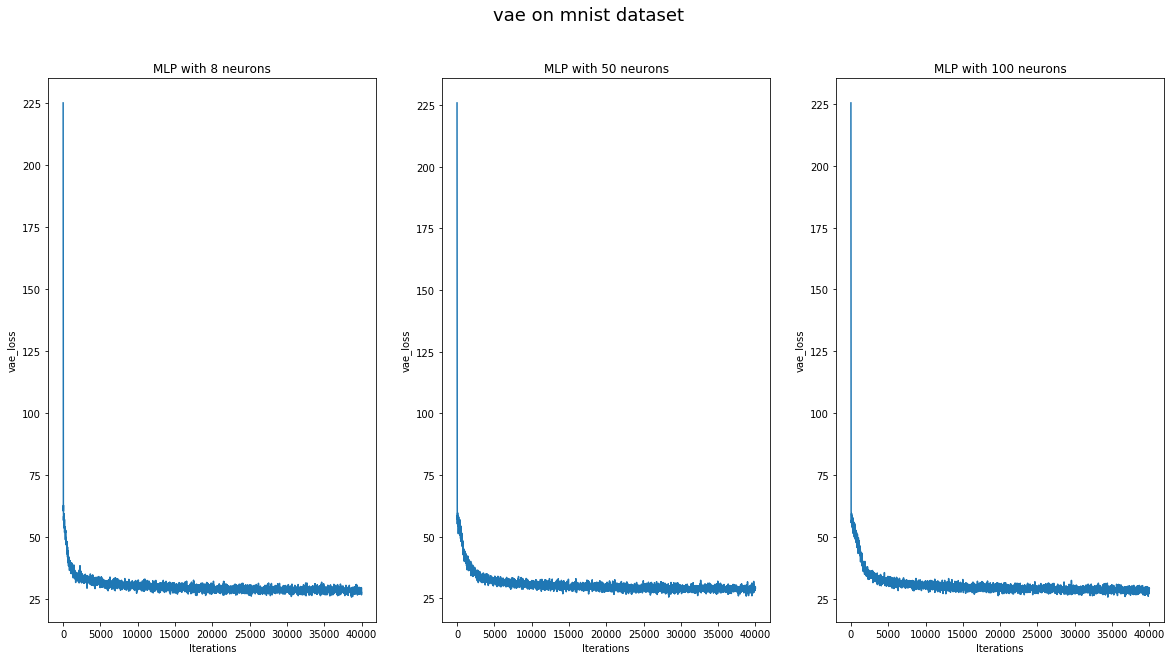

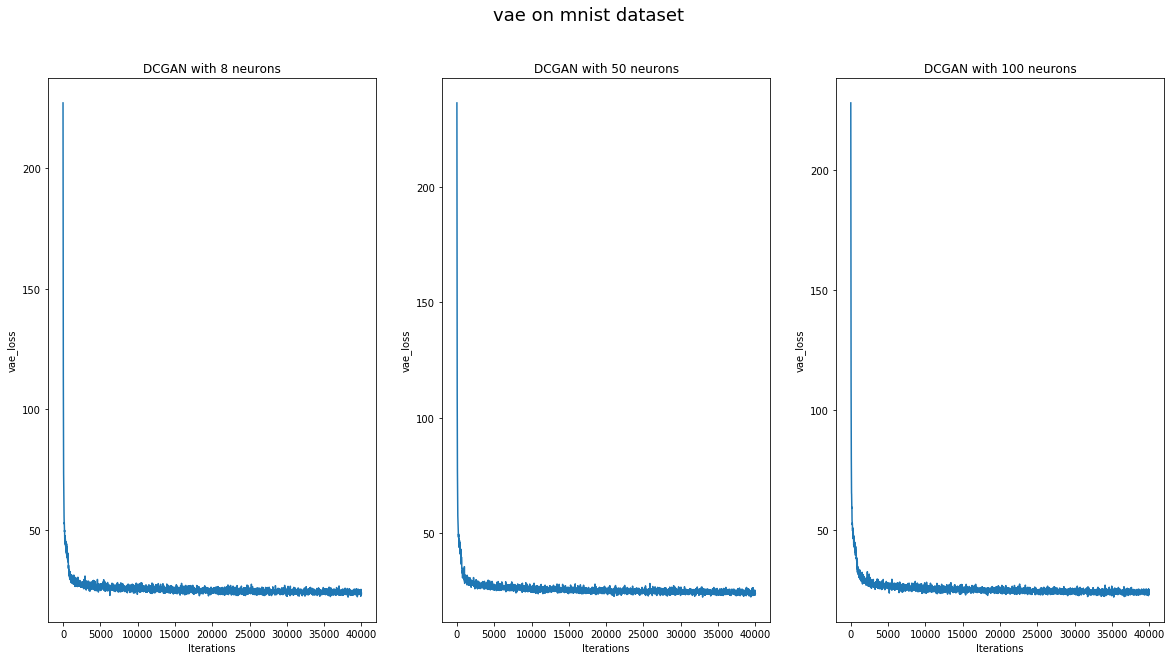

In [56]:
plot_loss('vae', 'mnist', 'mlp')
plot_loss('vae', 'mnist', 'dcgan')

Below are the VAE loss plots on CIFAR10 for the MLP and DCGAN architectures.

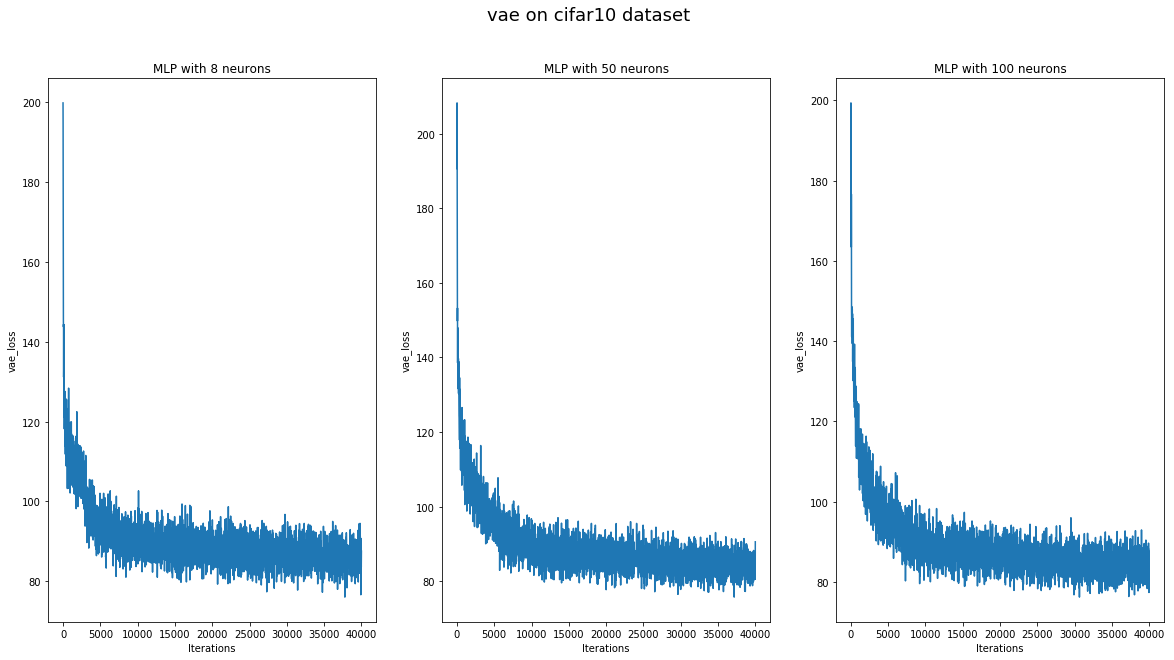

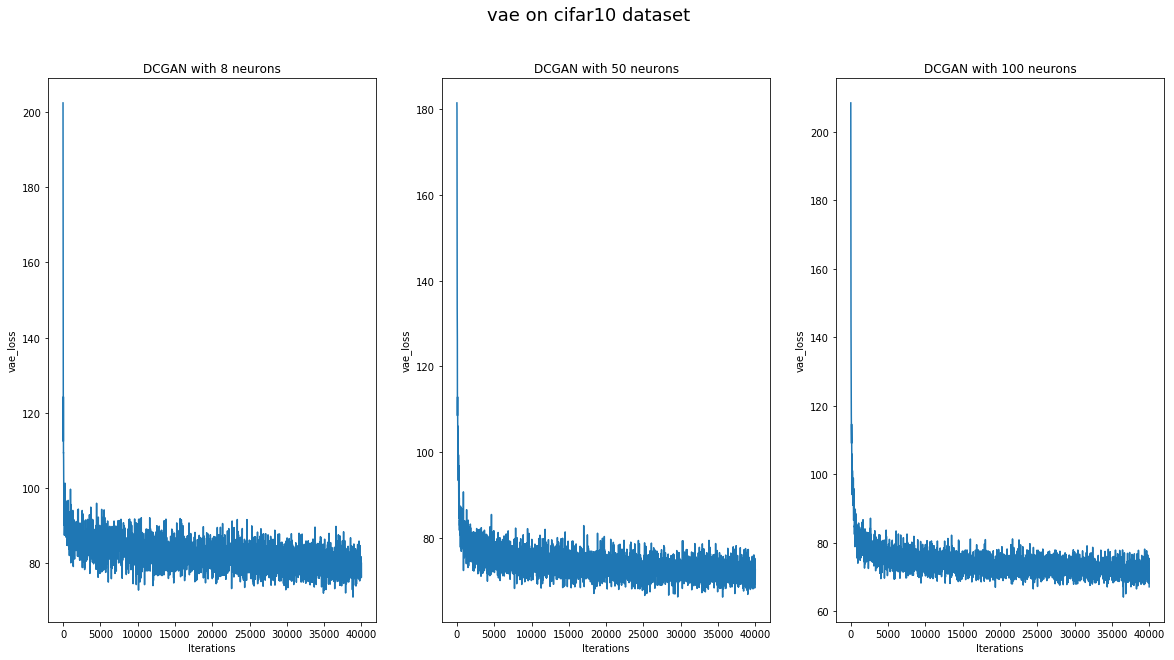

In [57]:
plot_loss('vae', 'cifar10', 'mlp')
plot_loss('vae', 'cifar10', 'dcgan')

Below are the GAN loss (JSD Estimate of the generator as described in the WGAN paper) plots on MNIST for the MLP and DCGAN architectures.

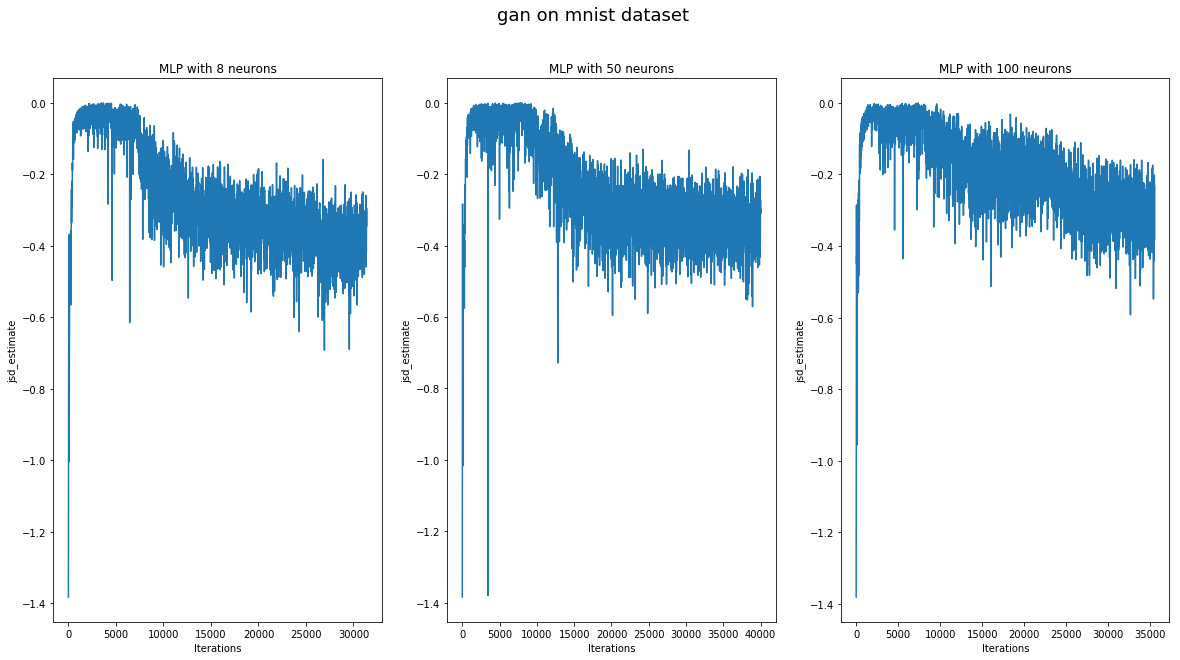

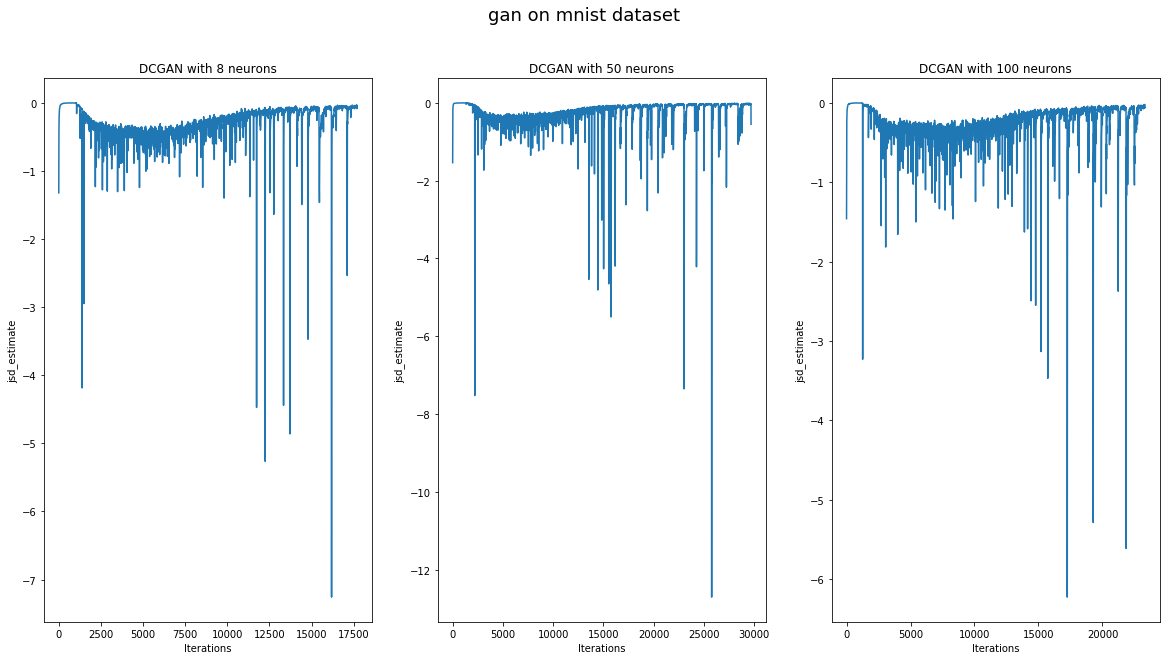

In [58]:
plot_loss('gan', 'mnist', 'mlp')
plot_loss('gan', 'mnist', 'dcgan')

Below are the GAN loss (JSD Estimate of the generator as described in the WGAN paper) plots on CIFAR10 for the MLP and DCGAN architectures.

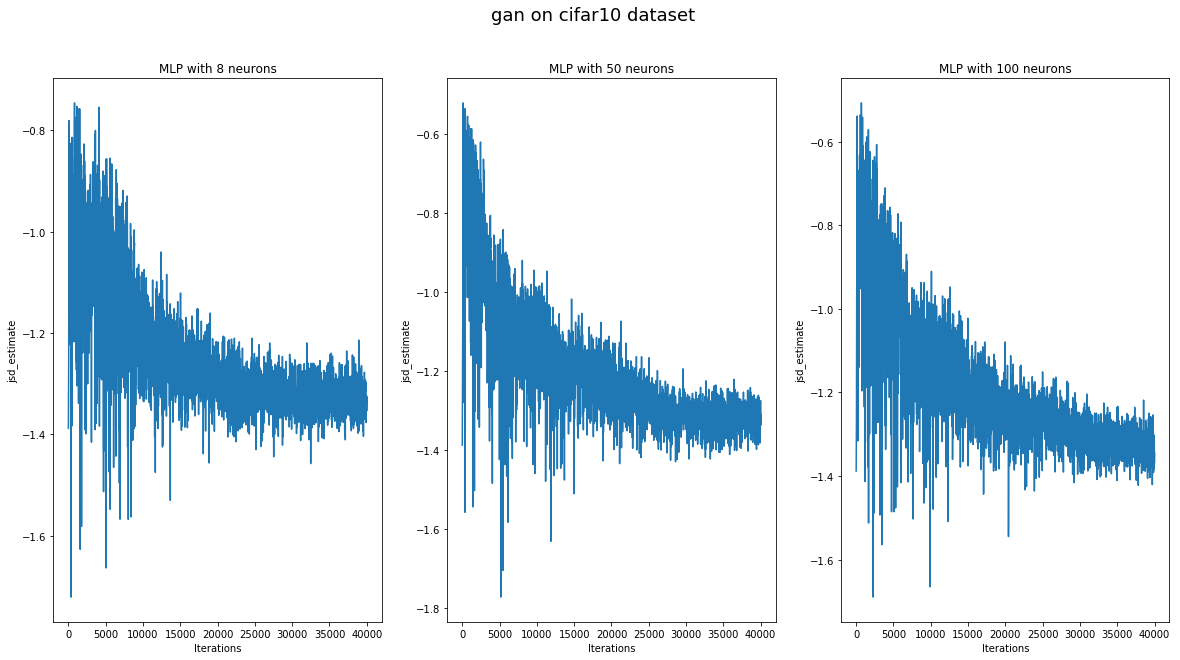

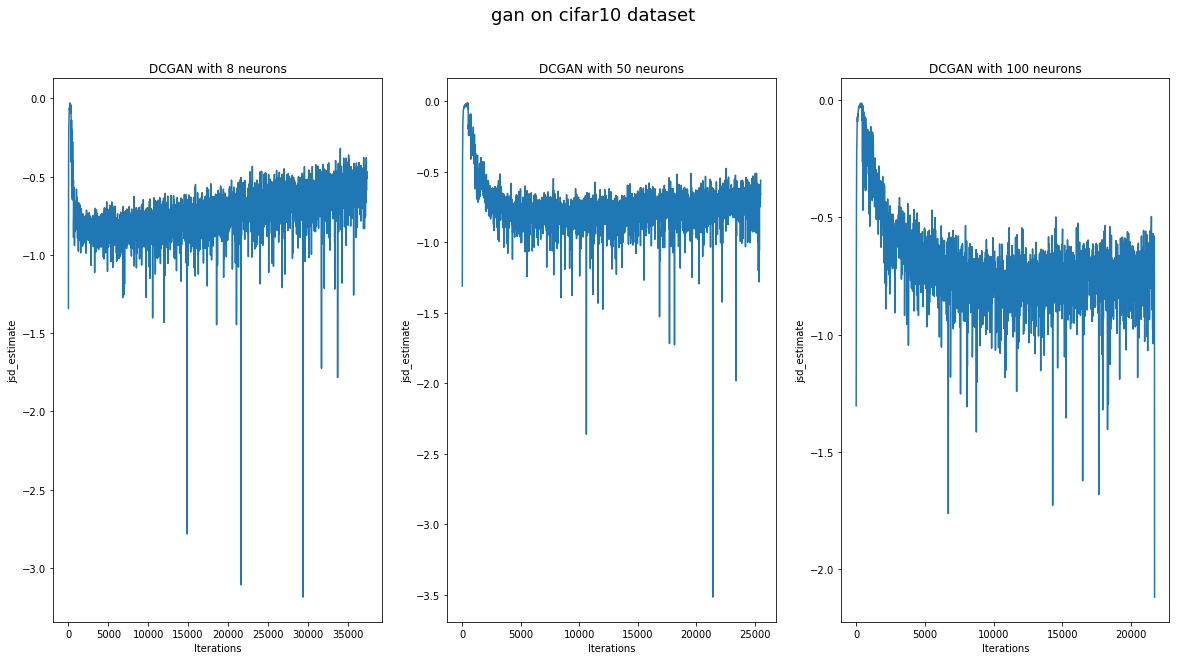

In [59]:
plot_loss('gan', 'cifar10', 'mlp')
plot_loss('gan', 'cifar10', 'dcgan')

Below are the Wasserstein distance plots on MNIST for the MLP and DCGAN architectures.

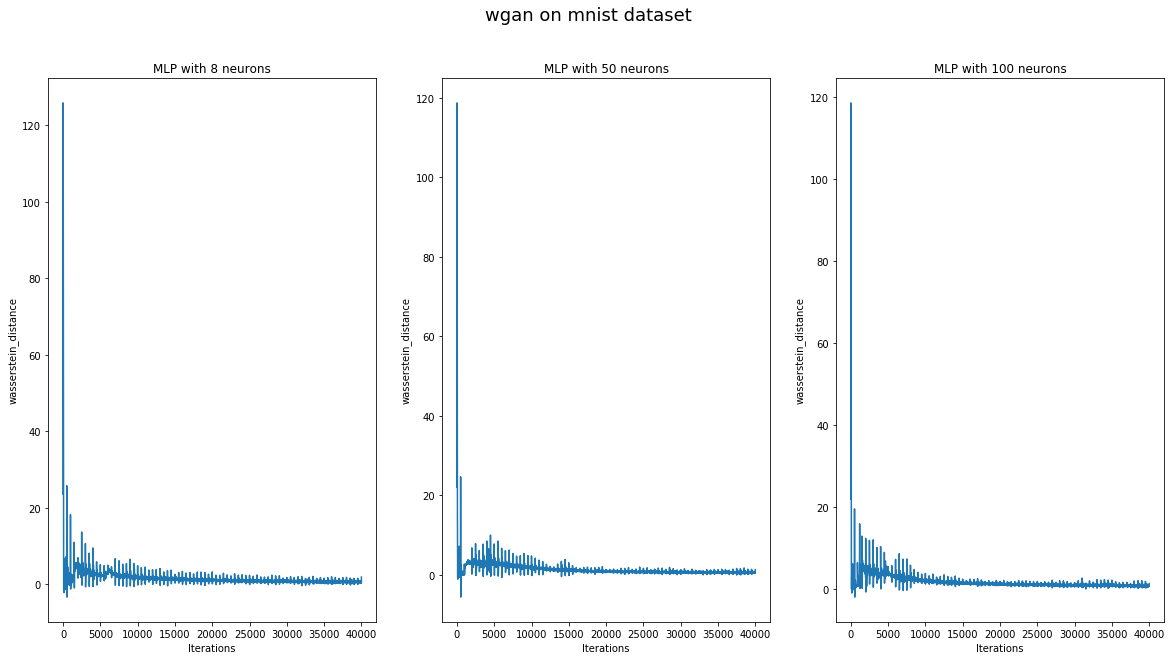

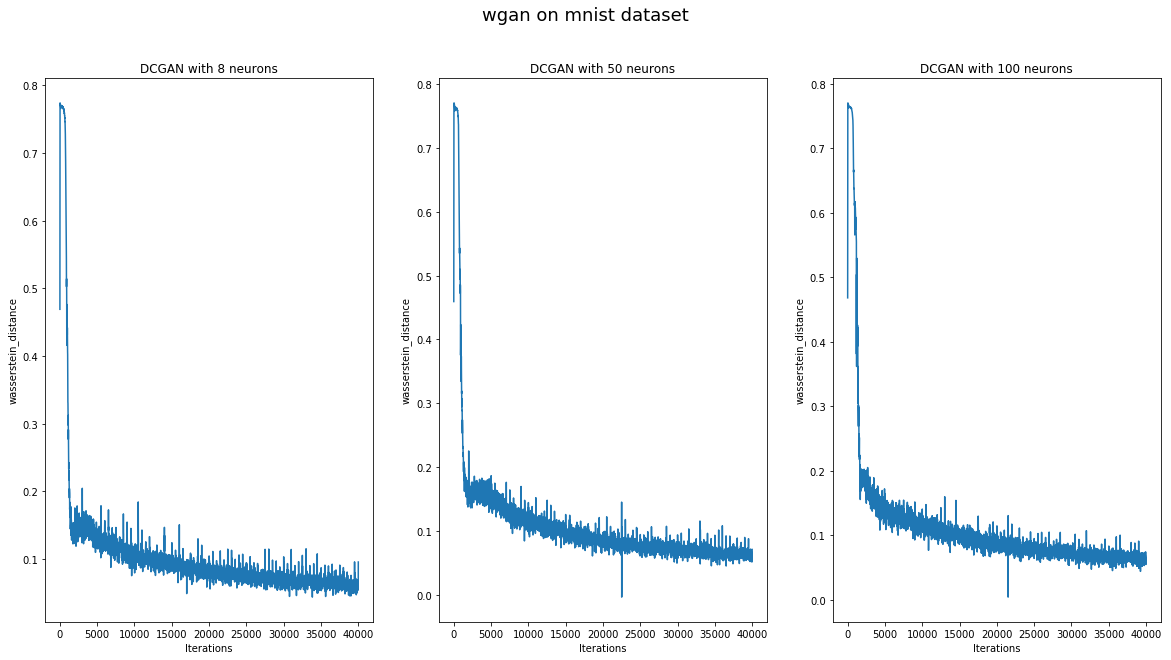

In [61]:
plot_loss('wgan', 'mnist', 'mlp')
plot_loss('wgan', 'mnist', 'dcgan')

Below are the Wasserstein distance plots on CIFAR10 for the MLP and DCGAN architectures.

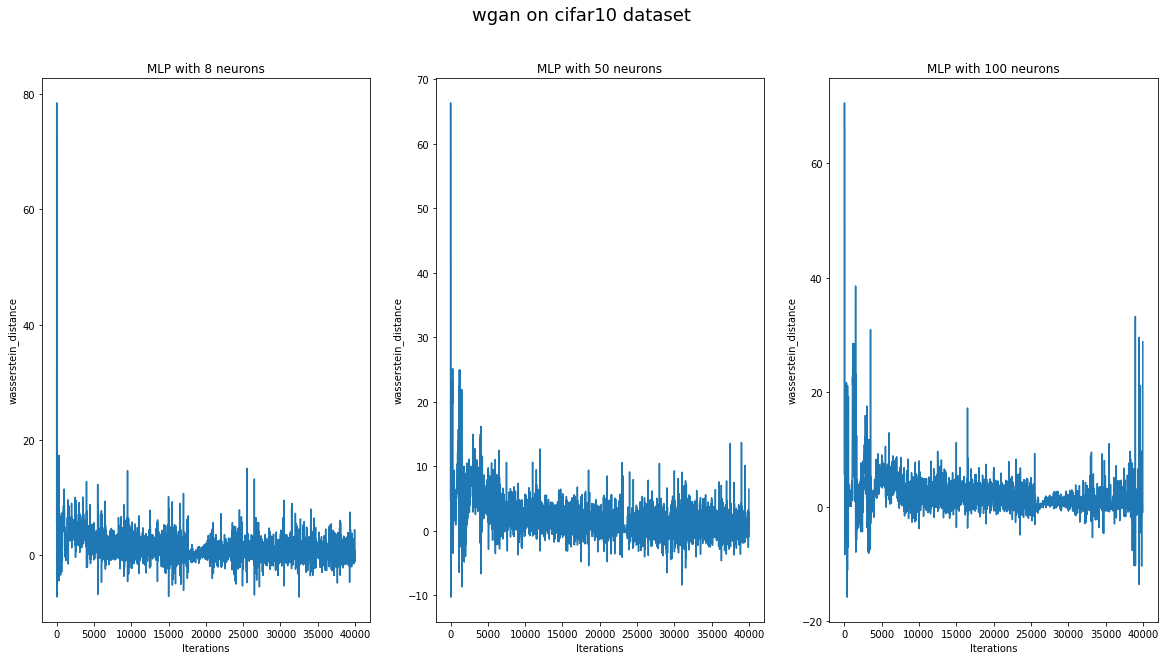

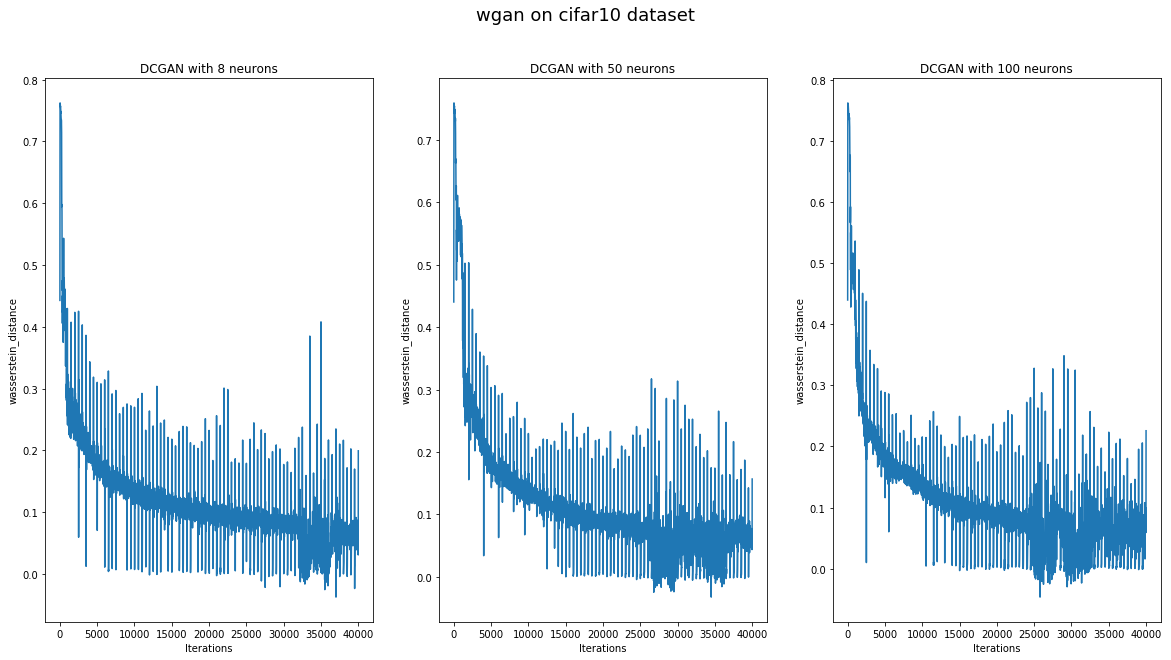

In [62]:
plot_loss('wgan', 'cifar10', 'mlp')
plot_loss('wgan', 'cifar10', 'dcgan')

In order not to make the final submission archive too big by including all the figures generated by the models, I only included two gifs: 
1. the VAE on MNIST with DCGAN architecture and 50 latent space
2. the WGAN on CIFAR10 with DCGAN architecture and 100 latent space

as they progress through the 40,000 iterations.
    
<table><tr>
    <td><img src="results/vae_mnist_dcgan_50.gif"> </td>
    <td><img src="results/wgan_cifar10_dcgan_100.gif"> </td>
</tr></table>

Also, below you can see the final generated images for each model:

### **MNIST:**

#### VAE:
<table>
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/mnist/results_mlp_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP VAE on MNIST (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/mnist/results_mlp_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP VAE on MNIST (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/mnist/results_mlp_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP VAE on MNIST (z=100)</div> </td>
</tr>    
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_dcgan_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN VAE on MNIST (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_dcgan_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN VAE on MNIST (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/mnist/results_dcgan_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN VAE on MNIST (z=100)</div> </td>
</tr></table>

#### GAN:
<table>
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/mnist/results_mlp_8_figs/fake_samples_it031400.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP GAN on MNIST (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/mnist/results_mlp_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP GAN on MNIST (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/mnist/results_mlp_100_figs/fake_samples_it035400.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP GAN on MNIST (z=100)</div> </td>
</tr>    
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/mnist/results_dcgan_8_figs/fake_samples_it017600.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN GAN on MNIST (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/mnist/results_dcgan_50_figs/fake_samples_it029600.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN GAN on MNIST (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/mnist/results_dcgan_100_figs/fake_samples_it023200.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN GAN on MNIST (z=100)</div> </td>
</tr></table>

#### WGAN:
<table>
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_mlp_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP WGAN on MNIST (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_mlp_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP WGAN on MNIST (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_mlp_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP WGAN on MNIST (z=100)</div> </td>
</tr>    
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_dcgan_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN WGAN on MNIST (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_dcgan_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN WGAN on MNIST (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/mnist/results_dcgan_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN WGAN on MNIST (z=100)</div> </td>
</tr></table>

### **CIFAR10:**

#### VAE:
<table>
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/cifar10/results_mlp_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP VAE on CIFAR10 (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/cifar10/results_mlp_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP VAE on CIFAR10 (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/cifar10/results_mlp_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP VAE on CIFAR10 (z=100)</div> </td>
</tr>    
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/cifar10/results_dcgan_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN VAE on CIFAR10 (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/cifar10/results_dcgan_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN VAE on CIFAR10 (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/vae/cifar10/results_dcgan_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN VAE on CIFAR10 (z=100)</div> </td>
</tr>
</table>

#### GAN:
<table>
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/cifar10/results_mlp_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP GAN on CIFAR10 (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/cifar10/results_mlp_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP GAN on CIFAR10 (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/cifar10/results_mlp_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP GAN on CIFAR10 (z=100)</div> </td>
</tr>    
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/cifar10/results_dcgan_8_figs/fake_samples_it037400.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN GAN on CIFAR10 (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/cifar10/results_dcgan_50_figs/fake_samples_it025400.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN GAN on CIFAR10 (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/gan/cifar10/results_dcgan_100_figs/fake_samples_it021600.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN GAN on CIFAR10 (z=100)</div> </td>
</tr>
</table>

#### WGAN:
<table>
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/cifar10/results_mlp_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP WGAN on CIFAR10 (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/cifar10/results_mlp_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP WGAN on CIFAR10 (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/cifar10/results_mlp_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />MLP WGAN on CIFAR10 (z=100)</div> </td>
</tr>  
<tr>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/cifar10/results_dcgan_8_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN WGAN on CIFAR10 (z=8)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/cifar10/results_dcgan_50_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN WGAN on CIFAR10 (z=50)</div> </td>
    <td><div style="width:image width px; font-size:80%; text-align:center;"><img src="results/wgan/cifar10/results_dcgan_100_figs/fake_samples_it040000.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />DCGAN WGAN on CIFAR10 (z=100)</div> </td>
</tr></table>

## Step 7 - Conclusion

As the WGAN paper proposes, the training using the Wasserstein distance leads to more stable and robusts results. This can be seen easily in the case of MNIST with MLP (in all the different latent sizes). With GAN the model experience mode collapse and only learns to produce realistic images of the digit one only. This is not happening in the case of WGAN where it successfully learns to generate digits of all classes (not so clear though given the generation power of an MLP network compare to DCGAN).

Also, a bigger number of steps should probably lead the VAE model to generate more clear images on CIFAR10 compared with the ones that were generated with 40,000 steps.